In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import joblib
import os
import torch
import random
from tqdm import tqdm

fontSizeSetLarge=18
fontSizeSetMedium=14
signalLims=[(0,50000),(0,5000), (0,2500), (0,4500)]
pceLims=(5,17.5)
vocLims=(0.9,1.15)
jscLims=(16,22)
ffLims=(40,75)   

def seedEverything(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed=42
seedEverything(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
filename='data/data.h5'

## read in and preprocess data

In [3]:
# Read the HDF5 file into a DataFrame
readDF=pd.read_hdf(filename, 'df') 
# Filter the DataFrame based on date, standard ratio, and standard molarity
readDF=readDF[(readDF["date"]>20230724) &(readDF["ratio"]==1) & (readDF["molarity"]==0.67)]

# List of signal types to process
signals=["ND","LP725","LP780","SP775"]

# Pad signals in the DataFrame to have the same length (1979)
for iy, signal in enumerate(signals):
    for ix in range(len(readDF)):
        temp1=readDF.loc[readDF.index[ix],signal]
        
        # Calculate how much padding is required and perform padding
        values_to_add = 1979 - len(temp1)
        constant_value = 0  
        temp1_padded = np.concatenate((temp1, [constant_value] * values_to_add))
        
        # Update the DataFrame with padded signals
        readDF.at[readDF.index[ix],signal]=temp1_padded
        
# Define samples that will be used as training data        
train_samples=[ 'DHM', 'DHN', 'DHO', 'DHP', 'DHQ' ,'DHR' ,
               'DGS', 'DGT', 'DGU' ,'DGV', 'DGW', 'DGX','DHS', 
               'DFS','DFT', 'DFU' ,'DFV', 'DFW' ,'DFX','DGR',
               'DEV' ,'DEW', 'DEX' ,'DFQ', 'DFR' ,'DGP','DGQ',
               'DAC', 'DAH' ,'DAM', 'DBC' ,'DBH', 'DBM', 'DBR', 'DCA', 'DCI', 'DDM', 'DDN' ,'DDO',
               'DDP', 'DDQ', 'DDR' ,'DDS' ,'DDT', 'DDU' ,'DDV', 'DDW' ,'DDX', 'DEM', 'DEN',
               'DES' ,'DET', 'DEU', 'DFO', 'DFP','DGM', 'DHV', 'DHW', 'DHX', 'DIU', 'DIV' ]

# Define sub-lists for different training folds during 5-fold cross-validation
train_fold0_sub_list=['DHM',  'DHR',  'DGW',  'DFU', 'DEV',  'DGP', 'DFO', 'DHX', 'DDO',  'DDT', 'DEM' ]
train_fold1_sub_list=[ 'DHN', 'DGS', 'DGX' , 'DFV', 'DEW', 'DGQ',  'DFP',  'DIU', 'DDP', 'DDU', 'DEN']
train_fold2_sub_list=[ 'DHO',  'DGT' , 'DHS',  'DFW', 'DEX', 'DES',  'DGM',  'DIV',  'DDQ',  'DDV']
train_fold3_sub_list=[ 'DHP', 'DGU', 'DFS' ,  'DFX' ,  'DFQ',  'DET', 'DHV', 'DDM', 'DDR',  'DDW']
train_fold4_sub_list=[ 'DHQ',  'DGV', 'DFT', 'DGR', 'DFR', 'DEU', 'DHW',  'DDN', 'DDS',  'DDX'  ]

# Drop samples not in any fold from the training DataFrame and reset its index
indexDropTrain = readDF[ ~readDF['expID'].isin(train_fold0_sub_list+train_fold1_sub_list+train_fold2_sub_list+train_fold3_sub_list+train_fold4_sub_list ) ].index
trainDF=readDF.drop(indexDropTrain)
trainDF=trainDF.reset_index(drop=True)

# Assigning fold numbers to each sample in trainDF
for element in trainDF[trainDF['expID'].isin(train_fold0_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=0
for element in trainDF[trainDF['expID'].isin(train_fold1_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=1
for element in trainDF[trainDF['expID'].isin(train_fold2_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=2
for element in trainDF[trainDF['expID'].isin(train_fold3_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=3
for element in trainDF[trainDF['expID'].isin(train_fold4_sub_list)].index.tolist():
    trainDF.loc[element,"fold"]=4
    
# Drop the train samples from the DataFrame to create a test set and reset its index
indexDropTest = readDF[ readDF['expID'].isin(train_samples) ].index
testDF=readDF.drop(indexDropTest)
testDF=testDF.reset_index(drop=True)

def filter(df):
    # Filter out rows where 'PCE_backward' is not available
    df=df[df['PCE_backward'].notna()]
    
    # Set threshold for 'PCE_backward' to be used
    thres_PCE=1
    
    # Filter the DataFrame to include only rows where 'PCE_backward' is larger than the threshold
    if thres_PCE>0:
        df=df[df['PCE_backward']>thres_PCE]
    
    df=df.reset_index(drop=True)
    
    return df

# Apply the `filter` function to the training and testing DataFrames.
# This ensures that only entries with 'PCE_backward' values above the threshold are retained.
trainDF, testDF = [filter(df) for df in (trainDF, testDF)]  

## Training random forest regressor for forecasting signals

In [4]:
evac_durations=sorted(trainDF["evac_duration"].unique())
ventings=[29,59,149,329,509,689,1769]
signals=["ND", "LP725","LP780","SP775"]  
saveModel=True

seed=42
# Definition of grid search parameters
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 19)] # Number of trees in random forest
max_features = ['sqrt', 'log2', None] # Number of features to consider at every split
max_depth = [2,4,None] # Maximum number of levels in tree
min_samples_split = [2, 5] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the param grid for grid search
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

for signal in signals:
    for ix, venting in enumerate(ventings):  
        for iy, evac_duration in enumerate(evac_durations[ix:]):

            temp = trainDF[trainDF["evac_duration"]==evac_duration]
            modelsavepath="models/forecasting_models/" +str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+".joblib"

            # Check if the model for current signal, venting and evac_duration already exists or if it needs to be trained
            if os.path.isfile(modelsavepath) == True:
                pass
            else:
                print("needs to be trained: ", signal, venting, evac_duration)
                
                # Define grid search
                rf_Grid = GridSearchCV(estimator = RandomForestRegressor(random_state=seed), param_grid = param_grid, cv = 3, verbose=1, n_jobs = -1, refit=True)

                # Get input data (X) and data which has to be forecasted (y)
                temp_train=temp.copy()
                X_train=pd.DataFrame(data=np.vstack(temp_train[signal].to_numpy())[:,:venting])
                y_train=pd.DataFrame(data=np.vstack(temp_train[signal].to_numpy())[:,venting:int(evac_duration)-1])

                X_test=pd.DataFrame(data=np.vstack(testDF[testDF["evac_duration"]==evac_duration][signal].to_numpy())[:,:venting])
                y_test=pd.DataFrame(data=np.vstack(testDF[testDF["evac_duration"]==evac_duration][signal].to_numpy())[:,venting:int(evac_duration)-1])
                
                # Train random forest model using grid search and cross validation (3-fold)
                rf_Grid.fit(X_train, y_train)
                
                resultDF=pd.DataFrame(data=rf_Grid.cv_results_)
                plt.plot(resultDF["split0_test_score"],alpha=0.2,label="split 0")
                plt.plot(resultDF["split1_test_score"],alpha=0.2,label="split 1")
                plt.plot(resultDF["split2_test_score"],alpha=0.2,label="split 2")
                plt.plot(resultDF["mean_test_score"], label="mean")
                plt.axvline(np.argmax(resultDF["mean_test_score"]),color="k", linestyle="dashed")
                plt.title(str(signal)+"_"+ str(venting)+"_"+str(evac_duration)+"\nbest:"+str( rf_Grid.best_params_), wrap=True)
                plt.ylabel("r2 on validation")
                plt.xlabel("different hyper parameter combinations")
                plt.legend()
                
                best_model_grid = rf_Grid.best_estimator_                
                s="best_params:"+ str( rf_Grid.best_params_)+" \n"
                s+="train error rf_Grid.score(X_train,y_train): "+ str(rf_Grid.score(X_train,y_train))+" \n"
                s+="test error rf_Grid.score(X_test,y_test): "+ str( rf_Grid.score(X_test,y_test))+" \n"
                s+="train error r2_score(best_model_grid.predict(X_train), y_train): "+ str(r2_score(best_model_grid.predict(X_train), y_train))+" \n"
                s+="test error r2_score(best_model_grid.predict(X_test), y_test): "+ str(r2_score(best_model_grid.predict(X_test), y_test) )+" \n"                           

                # Save random forest model to disk
                if saveModel==True:
                    plt.savefig(modelsavepath[:-7]+"_hyperParam_optim.png", dpi=200)
                    joblib.dump(best_model_grid, modelsavepath, compress=0)
                    resultDF.to_pickle(modelsavepath[:-7]+"_resultDF.pkl")  
                    with open(modelsavepath[:-7]+"_bestParams.txt", "w") as text_file:
                        text_file.write(s)
                plt.show()                

print("all models already exist")

all models already exist


## Forecasting results on held-out test set

ND 29 240.0


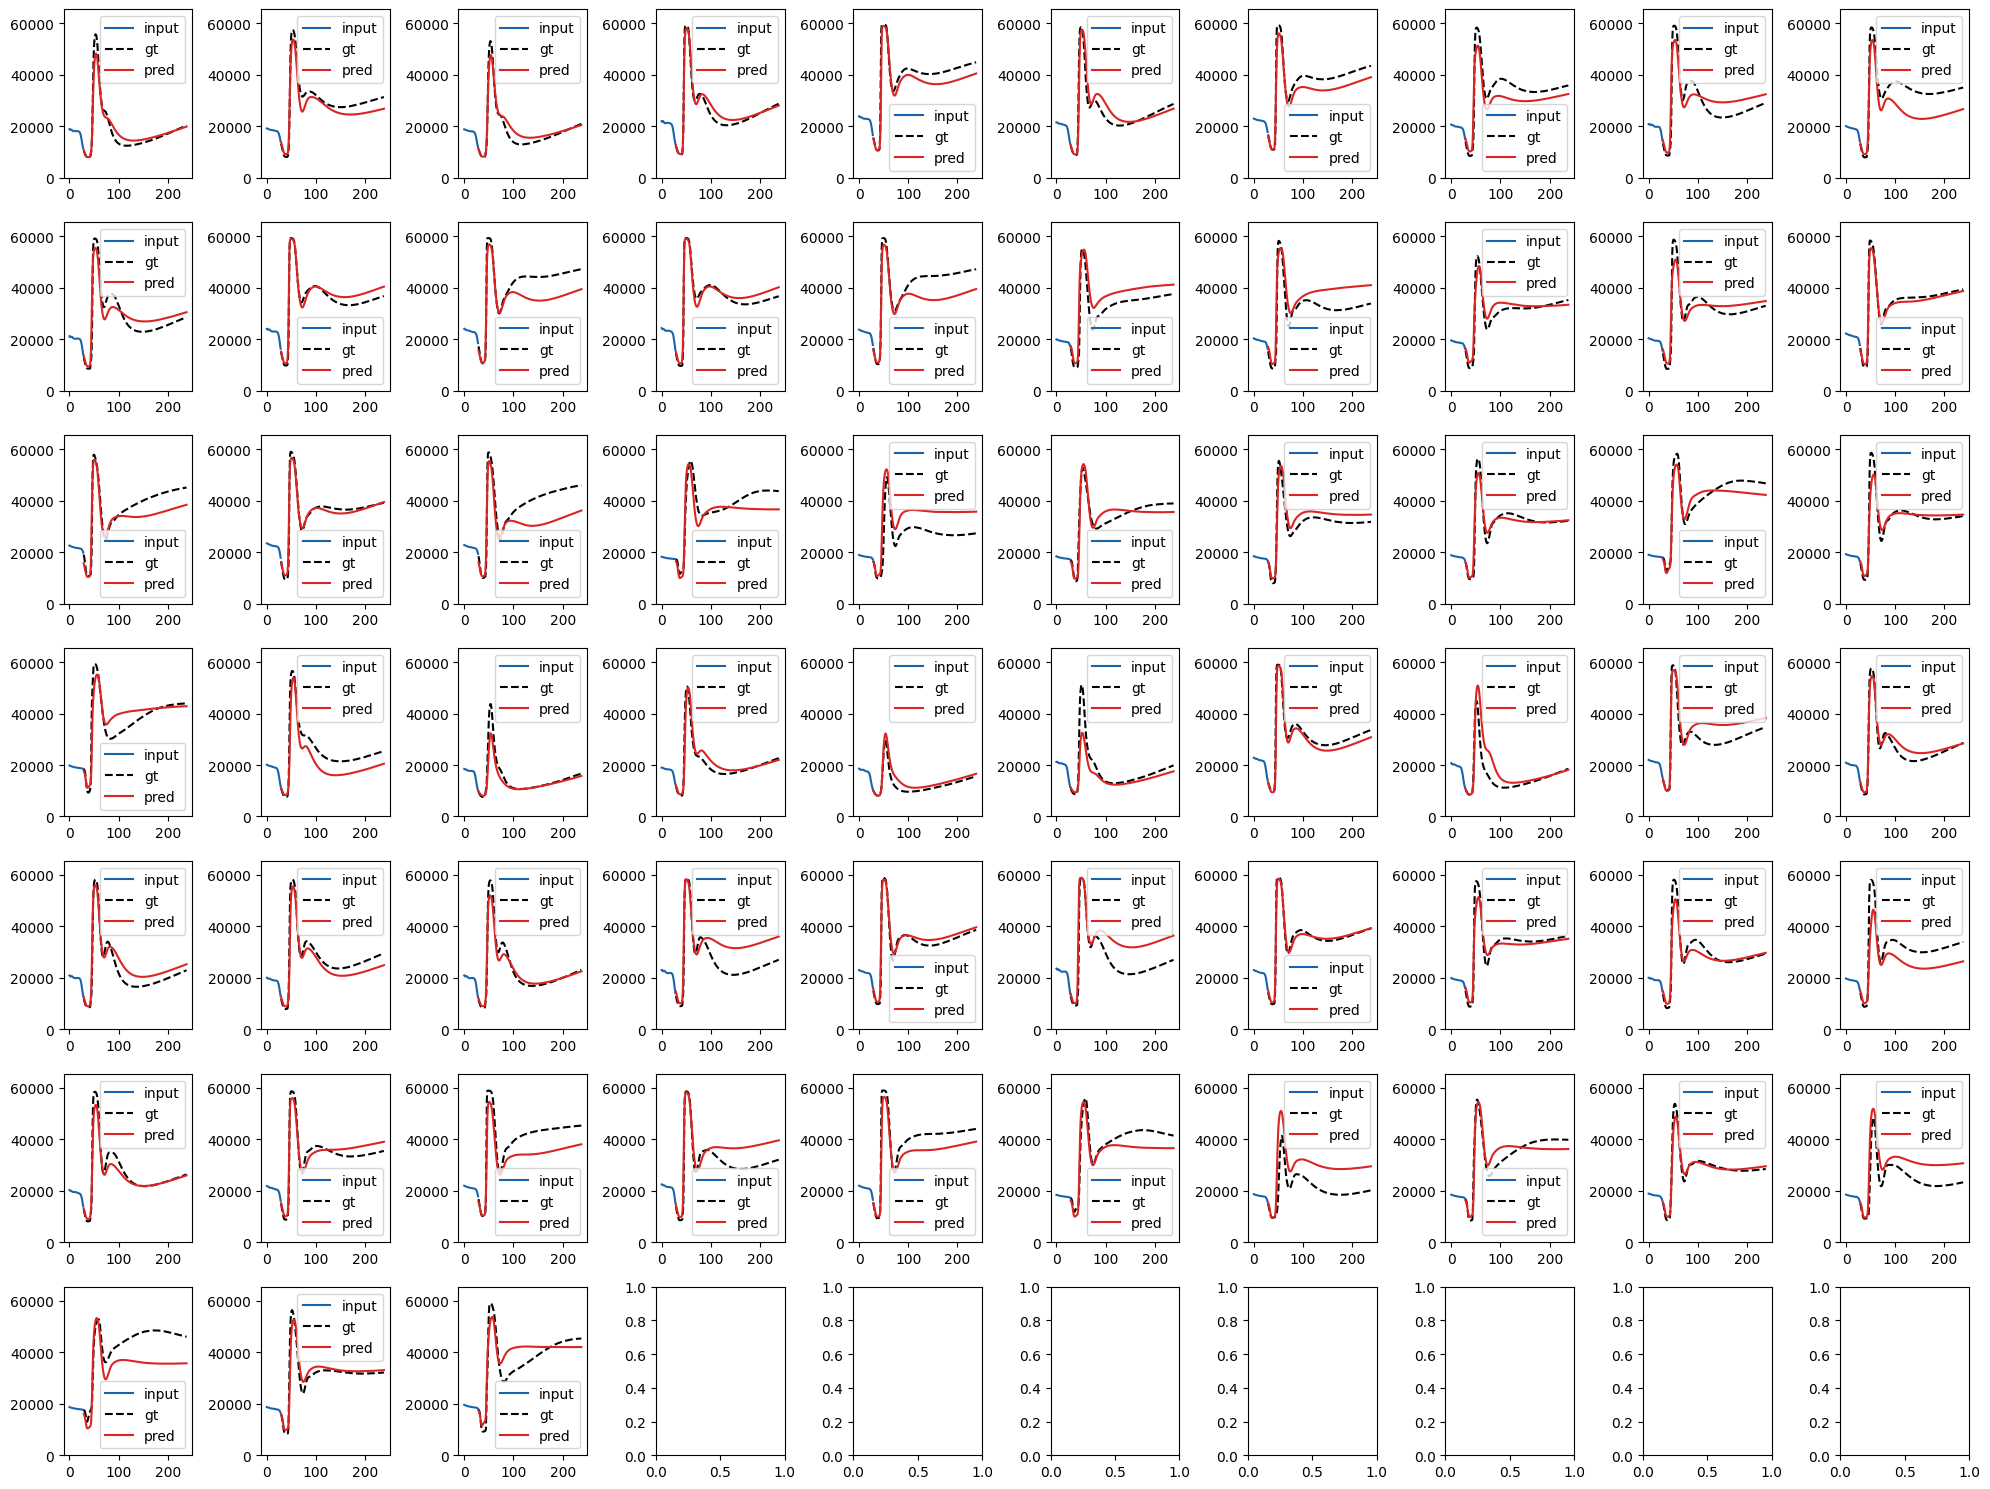

In [5]:
# Define the number of columns for subplots
noOfCols=10

# Loop through each signal type
for signal in signals:
    # Loop through each venting time
    for ix, venting in enumerate(ventings):  
        # Loop through each evacuation duration for the current venting time, skipping the last duration due to visualization reasons
        for iy, evac_duration in enumerate(evac_durations[ix:-1]):
            print(signal,venting,evac_duration)
            # Load the Random Forest model from file
            modelsavepath="models/forecasting_models/"+signal+"_" + str(venting)+"_"+str(evac_duration)+".joblib"
            rf_model = joblib.load(modelsavepath)
            
            # Filter the test dataset for the current evacuation duration
            temp = testDF[testDF["evac_duration"]==evac_duration]
            # Prepare the test input features and targets based on the signal and time slices
            X_test=pd.DataFrame(data=np.vstack(temp[signal].to_numpy())[:,:venting])
            y_test=pd.DataFrame(data=np.vstack(temp[signal].to_numpy())[:,venting:int(evac_duration)-1])
            
            # Use the loaded model to predict the test targets
            y_pred=rf_model.predict(X_test)

            # Determine the figure length based on the number of predictions
            fig_length = 50 if len(y_pred) > 150 else 15
            
            # Create a grid of subplots for visualizing the input signals, ground truth, and predictions
            fig, ax =plt.subplots(len(y_pred)//noOfCols+1, noOfCols, figsize=(20,fig_length))
            for inn in range(len(y_pred)):
                # Plot the input signal
                ax[inn//noOfCols,inn%noOfCols].plot(X_test.loc[inn,:], color=plt.get_cmap('Blues')(0.8), label="input")
                # Plot the ground truth (gt) signal continuation
                ax[inn//noOfCols,inn%noOfCols].plot(np.arange(len(X_test.loc[inn,:]),len(X_test.loc[inn,:])+len(y_test.loc[inn,:])),y_test.loc[inn,:], color="k", linestyle="dashed",label="gt")
                # Plot the predicted signal continuation / forecast
                ax[inn//noOfCols,inn%noOfCols].plot(np.arange(len(X_test.loc[inn,:]),len(X_test.loc[inn,:])+len(y_test.loc[inn,:])),y_pred[inn,:], color=plt.get_cmap('Reds')(0.7), label="pred")
                ax[inn//noOfCols,inn%noOfCols].legend()
                if signal=="ND":
                    ax[inn//noOfCols,inn%noOfCols].set_ylim(0,2**16)
                else:
                     ax[inn//noOfCols,inn%noOfCols].set_ylim(0,5000)
            fig.tight_layout()
            plt.show()
            # Break the loops early for demonstration
            break
        break
    break

## Forecasting signals for different quenching durations

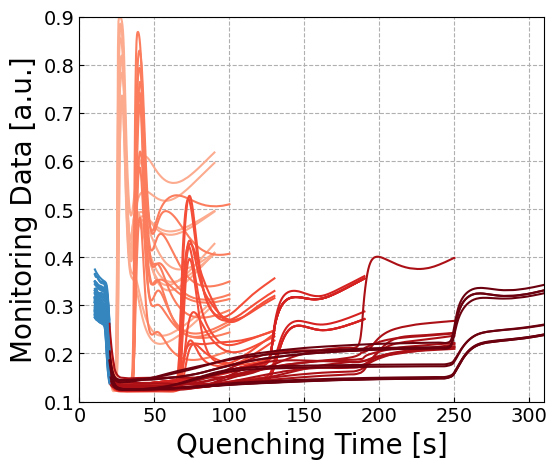

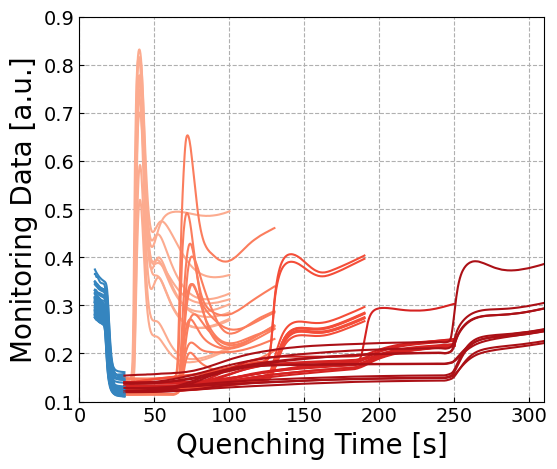

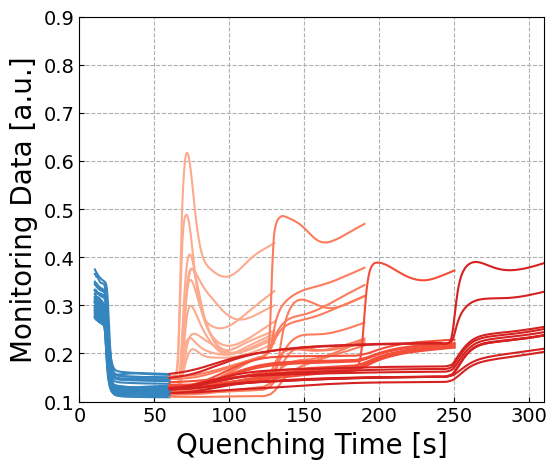

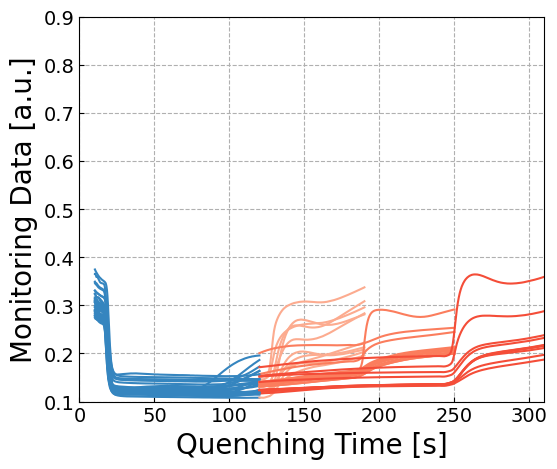

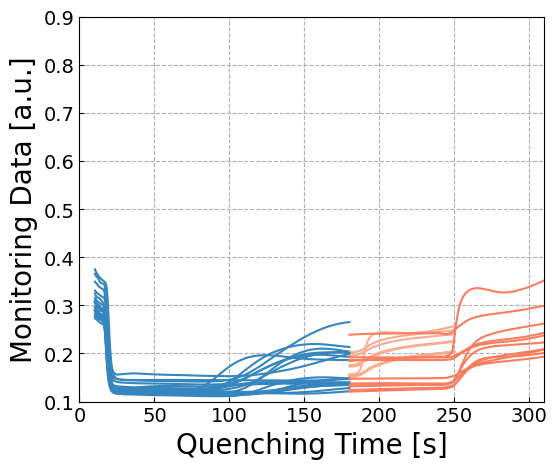

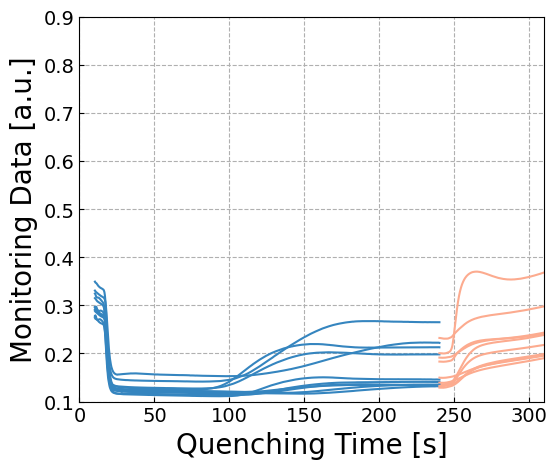

In [6]:
# Scaler value for normalizing data
scaler=2**16
# Generate color maps for plotting
ks = np.linspace(0.3,0.99,6)
ks2 = np.linspace(0.2,0.99,6)
color_list_fig = []
color_list_fig_2 = []
cmap = plt.get_cmap('Reds')
cmap2 = plt.get_cmap('Blues')
for zz in range(len(ks)):
    color_list_fig.append(cmap(ks[zz]))
    color_list_fig_2.append(cmap2(ks2[zz]))

# Loop through venting times, excluding the last one for comparison
for ix, venting in enumerate(ventings[:-1]):  
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    # Loop through evacuation durations for the current venting time
    for iy, evac_duration in enumerate(evac_durations[ix:-1]):
        # Load the Random Forest model
        modelsavepath="models/forecasting_models/ND_"+ str(venting)+"_"+str(evac_duration)+".joblib"
        rf_model = joblib.load(modelsavepath)
        
        # Filter test data for the current evacuation duration
        temp = testDF[testDF["evac_duration"]==evac_duration]
        # Prepare the test input features and targets based on the signal and time slices
        X_test=pd.DataFrame(data=np.vstack(temp["ND"].to_numpy())[:,:venting])
        y_test=pd.DataFrame(data=np.vstack(temp["ND"].to_numpy())[:,venting:int(evac_duration)-1])
        
        # Make predictions using the Random Forest model
        y_pred=rf_model.predict(X_test)
        
        # Plot the first 10 predictions for demonstration
        for ix in range(10): 
            # Plot normalized input data
            ax.plot(np.linspace(10.333333333333334, 10.333333333333334+len(X_test.iloc[ix])/3, len(X_test.iloc[ix])), X_test.iloc[ix]/scaler,color=color_list_fig_2[3], label="Input")          
            # Plot normalized predictions
            ax.plot(np.linspace(10.333333333333334+len(X_test.iloc[ix])/3, 10.333333333333334+len(X_test.iloc[ix])/3+len(y_pred[ix][:])/3, len(y_pred[ix][:])),y_pred[ix][:]/scaler,color=color_list_fig[iy],  label="Prediction")
  
    ax.grid(which="both", linestyle='--')
    ax.tick_params(axis='both', which='major',direction="in", labelsize=14) 
    ax.set_ylabel("Monitoring Data [a.u.]", fontsize=20)
    ax.set_xlabel("Quenching Time [s]", fontsize=20)
    ax.set_ylim(0.1,0.9)
    ax.set_xlim(0,310)
    plt.show()